# Computer Vision

### Commonly used libraries
1. `torchvision` - base domain
2. `torchvision.datasets` - get vision datasets
3. `torchvision.models` - get pretrained models
4. `torchvision.transforms` - functions for manipulating vision data
5. `torch.utils.data.Dataset`
6. `torch.utils.data.Dataloader`

### Import libraries

In [440]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__

('2.6.0+cu118', '0.21.0+cu118')

### Get datasets
We're going to use FashionMNIST

In [441]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),  # how we transform the data
    target_transform=None,  # how we transform the labels
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor(), target_transform=None
)

In [442]:
len(train_data), len(test_data)

(60000, 10000)

In [443]:
image, label = train_data[0]

In [444]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [445]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [446]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [447]:
print(f"image shape: {image.shape}\nlabel: {label}")

image shape: torch.Size([1, 28, 28])
label: 9


### Visualize the data

Text(0.5, 1.0, 'Ankle boot')

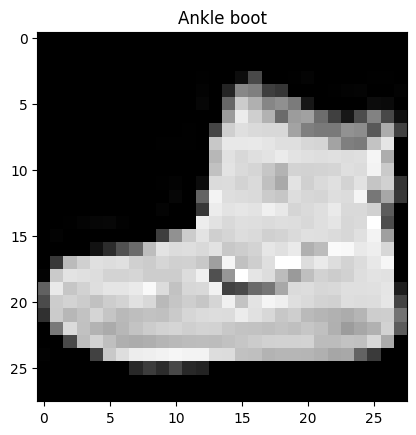

In [448]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="grey")
plt.title(class_names[label])

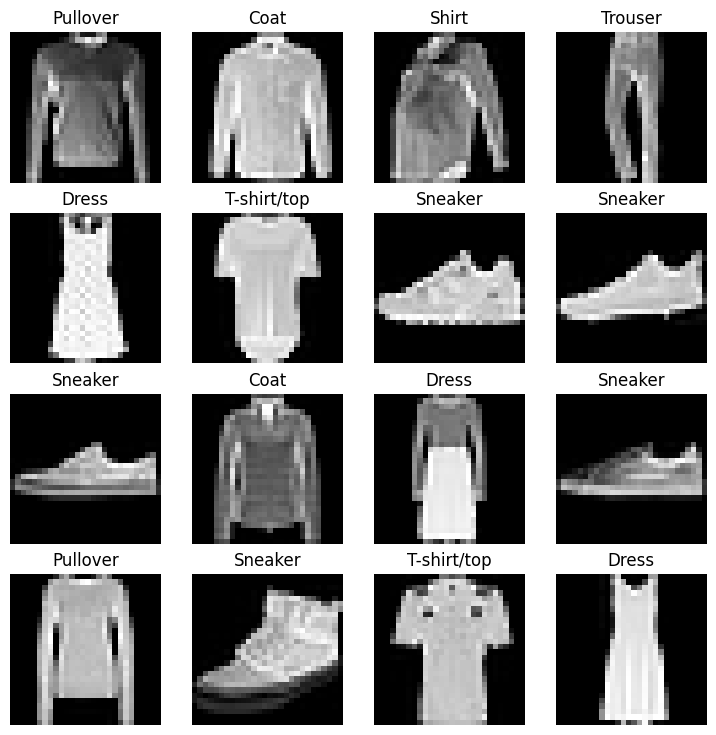

In [449]:
# torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

### Prepare DataLoader

In [450]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [451]:
print(f"length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

length of train dataloader: 1875 batches of 32
length of test dataloader: 313 batches of 32


In [452]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

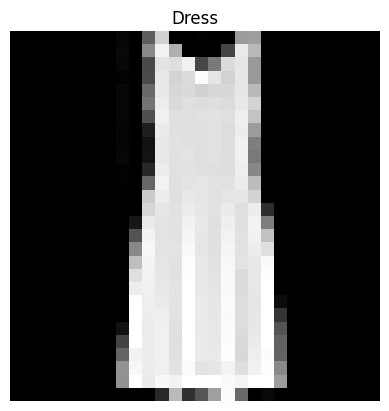

In [453]:
# torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label - train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

### Building a baseline model

In [454]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [455]:
from torch import nn


class FashionModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [456]:
torch.manual_seed(42)

model_0 = FashionModel(input_shape=784, output_shape=len(class_names), hidden_units=10)

model_0

FashionModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [457]:
dummy_x = torch.rand([1, 1, 28, 28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### Setup loss, optimizer, and eval metrics

In [458]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

acc_fn = Accuracy(task="multiclass", num_classes=len(class_names))

### Creating function to time experiment
Two things to track
1. Model's performance (loss and accuracy values)
2. How fast it runs

In [459]:
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


start_time = timer()
# some code...
end_time = timer()

print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


3.310013562440872e-05

In [460]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_cpu = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_preds = model_0(X)

        loss = loss_fn(y_preds, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_preds = model_0(X_test)

            test_loss += loss_fn(test_preds, y_test)
            test_acc += acc_fn(test_preds.argmax(dim=1), y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(
        f"train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f} | test_accuracy: {test_acc:.2f}"
    )

# print train time
train_time_end_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_cpu,
    end=train_time_end_cpu,
    device=str(next(model_0.parameters()).device),
)

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:12<00:25, 12.77s/it]

train_loss: 0.5904 | test_loss: 0.5095 | test_accuracy: 0.82
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:28<00:14, 14.34s/it]

train_loss: 0.4763 | test_loss: 0.4799 | test_accuracy: 0.83
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:44<00:00, 14.80s/it]

train_loss: 0.4550 | test_loss: 0.4766 | test_accuracy: 0.83
Train time on cpu: 44.418 seconds


In [461]:
torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
):
    """Returns a dictionary containg the results of model predicting on data_loader"""

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_preds = model(X)

            loss += loss_fn(y_preds, y)
            acc += accuracy_fn(y_preds.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item(),
    }


model_0_results = eval_model(
    model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=acc_fn
)
model_0_results

{'model_name': 'FashionModel',
 'model_loss': 0.47663894295692444,
 'model_acc': 0.8342651724815369}

## Model 1: Adding Non-Linear Activations

### Setting up device agnostic code

In [462]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Creating model class

In [463]:
from torch import nn


class FashionModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)


model_1 = FashionModelV1(
    input_shape=784, output_shape=len(class_names), hidden_units=10
).to(device)

### Create loss, optimizer, and accuracy functions

In [464]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

### Create functions for train step and test step

In [465]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    """performs training loop step"""
    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_preds = model(X)

        loss = loss_fn(y_preds, y)
        train_loss += loss

        train_acc = accuracy_fn(y_preds.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train_loss: {train_loss:.5f} | train_acc: {train_acc.item():.2f}%")


def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    """performs testing loop step"""

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_preds = model(X_test)
            test_loss += loss_fn(test_preds, y_test)
            test_acc += accuracy_fn(test_preds.argmax(dim=1), y_test)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"test_loss: {test_loss:.5f} | test_acc: {test_acc.item():.2f}%")

### Run the train and test

In [466]:
from timeit import default_timer as timer

torch.manual_seed(42)

# Measure Time

train_time_start = timer()
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=device,
    )
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=device,
    )

train_time_end = timer()

total_train_time_model_1 = print_train_time(
    start=train_time_start, end=train_time_end, device=device
)

Epoch: 0
---------
train_loss: 0.98248 | train_acc: 0.00%
test_loss: 0.76060 | test_acc: 0.73%
Epoch: 1
---------
train_loss: 0.70366 | train_acc: 0.00%
test_loss: 0.71731 | test_acc: 0.74%
Epoch: 2
---------
train_loss: 0.67375 | train_acc: 0.00%
test_loss: 0.69170 | test_acc: 0.75%
Train time on cuda: 77.093 seconds


### Evaluate model

In [467]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device,
):
    """Returns a dictionary containg the results of model predicting on data_loader"""

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_preds = model(X)

            loss += loss_fn(y_preds, y)
            acc += accuracy_fn(y_preds.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item(),
    }


model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=acc_fn,
    device=device,
)

model_1_results

{'model_name': 'FashionModelV1',
 'model_loss': 0.6917040348052979,
 'model_acc': 0.7481030225753784}

## Model 2: Making a Convolutional Neural Network

### Code the model

In [468]:
class FashionModelV2(nn.Module):
    """"""

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

torch.Size([1, 28, 28])

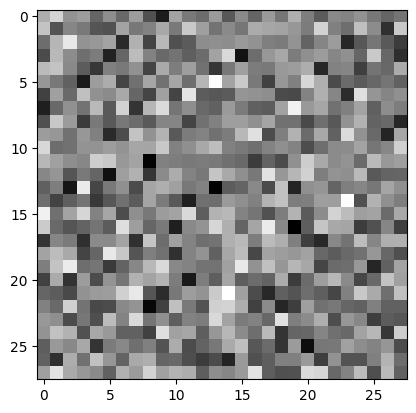

In [469]:
model_2 = FashionModelV2(
    input_shape=1, hidden_units=10, output_shape=len(class_names)
).to(device)


image = torch.randn(size=(1, 28, 28))
plt.imshow(image.squeeze(), cmap="gray")
image.shape

In [470]:
# model_2(image.unsqueeze(dim=0).to(device))

### Creating random data

In [471]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))

test_image = images[0]

print(f"image batch shape: {images.shape}")
print(f"single image: {test_image.shape}")
print(f"test image:\n{test_image}")

image batch shape: torch.Size([32, 3, 64, 64])
single image: torch.Size([3, 64, 64])
test image:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978, 

In [472]:
conv_layer = nn.Conv2d(
    in_channels=3, out_channels=10, kernel_size=(3, 3), stride=1, padding=1
)
conv_output = conv_layer(test_image)

conv_output.shape

torch.Size([10, 64, 64])

### Stepping through mm.MaxPool2d()

In [473]:
print(f"Test image original shape: {test_image.shape}")
print(f"test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass through conv layer
test_image_through_conv = conv_layer(test_image)
print(f"test image through conv layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(
    f"test image after max pool and conv: {test_image_through_conv_and_max_pool.shape}"
)

Test image original shape: torch.Size([3, 64, 64])
test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
test image through conv layer: torch.Size([10, 64, 64])
test image after max pool and conv: torch.Size([10, 32, 32])


In [474]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2))

max_pool_layer = nn.MaxPool2d(kernel_size=2)


max_pool_tensor = max_pool_layer(random_tensor)
print(f"max pool tensor: {max_pool_tensor}")
print(f"max pool tensor shape: {max_pool_tensor.shape}")

random_tensor

max pool tensor: tensor([[[[0.3367]]]])
max pool tensor shape: torch.Size([1, 1, 1, 1])


tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

In [475]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [476]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    train_step(
        model=model_2,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=device,
    )
    test_step(
        model=model_2,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=device,
    )

train_time_end = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start, end=train_time_end, device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

train_loss: 0.58946 | train_acc: 0.00%


 33%|███▎      | 1/3 [00:25<00:51, 25.95s/it]

test_loss: 0.40105 | test_acc: 0.86%
train_loss: 0.35702 | train_acc: 0.00%


 67%|██████▋   | 2/3 [00:50<00:25, 25.26s/it]

test_loss: 0.34888 | test_acc: 0.88%
train_loss: 0.32026 | train_acc: 0.00%


100%|██████████| 3/3 [01:15<00:00, 25.04s/it]

test_loss: 0.33098 | test_acc: 0.88%
Train time on cuda: 75.122 seconds


In [477]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=acc_fn,
    device=device,
)

model_2_results

{'model_name': 'FashionModelV2',
 'model_loss': 0.3309801518917084,
 'model_acc': 0.879792332649231}

In [478]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionModel,0.476639,0.834265
1,FashionModelV1,0.691704,0.748103
2,FashionModelV2,0.330980,0.879792


In [479]:
compare_results["training_time"] = [
    total_train_time_model_0,
    total_train_time_model_1,
    total_train_time_model_2,
]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionModel,0.476639,0.834265,44.417627
1,FashionModelV1,0.691704,0.748103,77.093116
2,FashionModelV2,0.330980,0.879792,75.122239


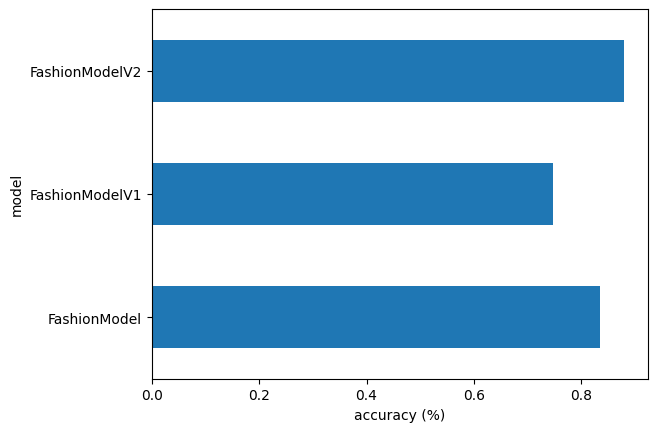

In [480]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [493]:
def make_predictions(
    model: torch.nn.Module, data: list, device: torch.cuda.device = device
):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [526]:
import random

# random.seed(42)
test_samples = []
test_labels = []

for (
    sample,
    label,
) in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Ankle boot')

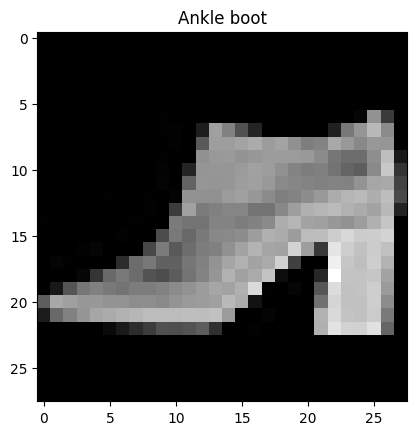

In [527]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [528]:
pred_probs = make_predictions(model=model_2, data=test_samples)

pred_probs

tensor([[4.8048e-06, 4.1390e-07, 9.1165e-07, 2.3672e-06, 6.6617e-06, 5.4338e-02,
         4.4884e-05, 8.5066e-04, 1.9872e-03, 9.4276e-01],
        [1.6262e-05, 7.4379e-06, 2.2365e-03, 5.9410e-07, 9.9560e-01, 1.0472e-07,
         2.0920e-03, 1.3865e-07, 4.3879e-05, 8.8476e-07],
        [5.2516e-02, 1.7350e-03, 4.2045e-01, 7.0797e-04, 2.9160e-02, 4.0054e-04,
         4.9264e-01, 1.2732e-05, 2.3447e-03, 3.2035e-05],
        [2.2832e-06, 1.2468e-07, 1.3057e-06, 1.1321e-07, 2.2906e-07, 1.9243e-04,
         1.8706e-05, 2.9330e-03, 7.2886e-04, 9.9612e-01],
        [1.4907e-06, 3.2409e-08, 9.2271e-08, 1.1287e-06, 4.7588e-07, 2.7384e-04,
         4.7105e-07, 9.9959e-01, 4.9759e-05, 8.2838e-05],
        [8.7099e-01, 9.0528e-07, 2.0716e-04, 4.9057e-04, 7.9627e-06, 5.8436e-07,
         1.2830e-01, 2.1923e-07, 3.8906e-06, 4.9413e-07],
        [5.0236e-05, 1.0030e-03, 1.2836e-04, 9.8460e-05, 9.8939e-01, 5.0447e-05,
         8.0555e-03, 3.3908e-07, 1.2228e-03, 8.7194e-07],
        [9.4313e-01, 2.1635

In [529]:
pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels

tensor([9, 4, 6, 9, 7, 0, 4, 0, 5])

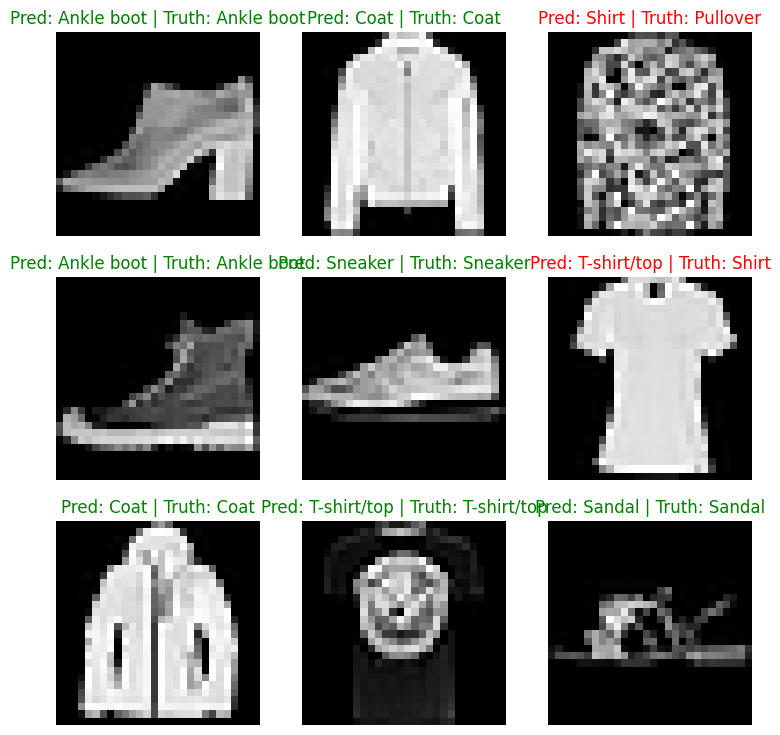

In [530]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_labels[i]]
    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, c="g")
    else:
        plt.title(title_text, c="r")

    plt.axis(False)

### Creating a confusion matrix


In [ ]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.argmax(y_logit.squeeze(), dim=1)

        y_preds.append(y_pred.cpu())

y_preds_tensor = torch.cat(y_preds)

Making predictions...: 100%|██████████| 313/313 [00:03<00:00, 89.15it/s] 


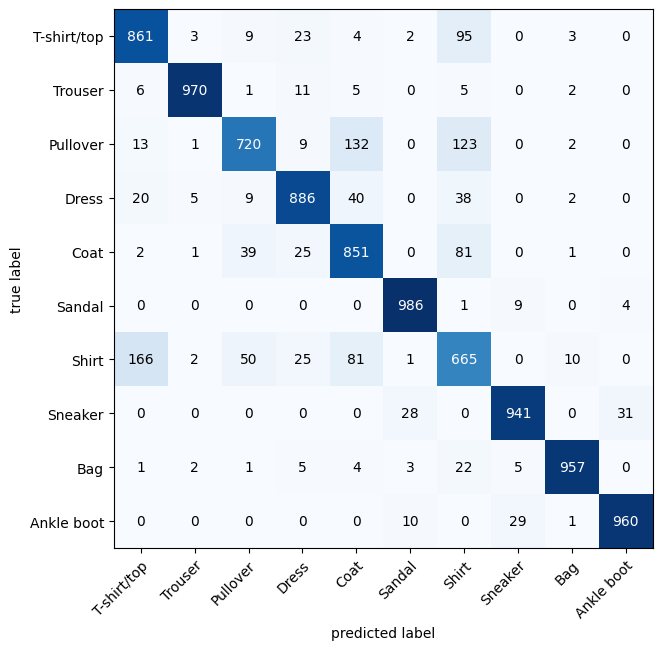

In [557]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7)
)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [564]:
torch.manual_seed(42)

loaded_model = FashionModelV2(
    input_shape=1, hidden_units=10, output_shape=len(class_names)
)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

FashionModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=acc_fn,
    device=device,
)

{'model_name': 'FashionModelV2',
 'model_loss': 0.3309801518917084,
 'model_acc': 0.879792332649231}

In [ ]:
loaded_model_results, model_2_results

({'model_name': 'FashionModelV2',
  'model_loss': 0.3309801518917084,
  'model_acc': 0.879792332649231},
 {'model_name': 'FashionModelV2',
  'model_loss': 0.3309801518917084,
  'model_acc': 0.879792332649231})

In [568]:
torch.isclose(
    torch.tensor(model_2_results["model_loss"]),
    torch.tensor(loaded_model_results["model_loss"]),
    atol=1e-02,
)

tensor(True)